# Capstone Project
Author: Izzie Nielsen

### Data Importing
Importing data from Human vs. AI Generated Essays dataset

##### Steps:


*   Upload the the dataset to Colab
*   Ensure the unzip file name matches your file name
*   Unzip the file
*   Read the csv
*   Store essays and labels in a dataframe



Note: will also allow user input eventually

In [1]:
!unzip archive.zip

Archive:  archive.zip
replace balanced_ai_human_prompts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd

df = pd.read_csv('/content/balanced_ai_human_prompts.csv')

display(df.head())
display(df.columns)

texts = df['text']

y = df['generated']

,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


Index(['text', 'generated'], dtype='object')

### Tokenization and Text Pre-Processing

Preparing the text before inputing into the models. First, the data is split into test and training (80/20 split). Then the training and testing esssays (X) are tokenized by the BertTokenizer. SVM and BERT have different vectorization requirements.

For the BERT model:
* Save the training and testing tokens into a dataset
* Add attention mask to help the model ignore unimportant tokens
* Add labels to the dataset for supervised learning

For SVM:
* Use TF-IDF vectorization to assign values to the words
* Remove stop words




In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)


## DeBERTa V3 small Model

Why this NLP?:
* Small model with fewer parameters, allowing it can run on my laptop
* High performance
* Great speed
* Better performance with essay data than BERT

Before Running the Model:
* Ensure required libraries are installed (transformers, datasets, torch, and evauluation)
    * use pip install
* Get an API key
    * https://wandb.ai/authorize?ref=models
    * You will need to make a free account

Steps:
* Import required libraries
* Create tokenizer and model
* Tokenize training and testing data
    * Max length of 512 due to model limitations
* Create Vector DB
    * Uses a torch database
    * Attention mask to keep model focused on important parameters
* Create Training arguments
* Train the NLP on the data
* Measure metrics using F-Score

Results so far:
* F-Score = 0.9962264150943396
    * Indicates High accuracy and recall
    * High F-score indicates robust model performance

Future work:
* Not all of the essay is being evaluated due to token constraints (essay length of 800 words is more than 512 tokens), therefore I am planning on chunking the input
* Generating more performance metrics for the model
* Potentially adjusting some hyperparameters to improve performance


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
train_tokens = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_tokens = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')

In [7]:
train_dataset = Dataset.from_dict({
    'input_ids': train_tokens['input_ids'],
    'attention_mask': train_tokens['attention_mask'],
    'labels': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_tokens['input_ids'],
    'attention_mask': test_tokens['attention_mask'],
    'labels': y_test.tolist()
})

In [9]:
training_args = TrainingArguments(
    output_dir="/content/deberta-small-essay-detector",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    load_best_model_at_end=True,
)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: izzienielsen (izzienielsen-creighton-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.008300,0.026248
2,0.010000,0.019515
3,0.000400,0.017369


TrainOutput(global_step=414, training_loss=0.03952159035550475, metrics={'train_runtime': 330.1941, 'train_samples_per_second': 19.988, 'train_steps_per_second': 1.254, 'total_flos': 874315973836800.0, 'train_loss': 0.03952159035550475, 'epoch': 3.0})

In [13]:
import evaluate
metric = evaluate.load("f1")

preds = trainer.predict(test_dataset)
logits = preds.predictions
y_pred = torch.argmax(torch.tensor(logits), dim=1)

f1 = metric.compute(predictions=y_pred, references=y_test.tolist())
print("F1 Score:", f1)

F1 Score: {'f1': 0.9962264150943396}


## SVM

1. Preprocessing
    
    * TF-IDF vectorization is used to allow the computer to understand the complex text data.

2. Model Creation

    * Create SVM model and train it using the vectorized training essays and labels for a supervised approach.
  
3. Evaulate Model Performance

    * Calculate accuracy, precision, and recall to determine performance

    * Generate Confusion Matrix

4. Evaluate for Overfitting


In [ ]:
#takes tokens and assigns values
#only used by SVM
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = SVC(kernel='rbf', gamma = 'scale', C=1)
model.fit(X_train_tfidf, y_train)

SVC(C=1)

In [ ]:
# grid search to determine the best hyper parameters
# ensures more generalization
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters:\n{grid_search.best_params_}")

best_model = grid_search.best_estimator_


Best parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9963636363636363
Precision: 1.0
Recall: 0.9924812030075187


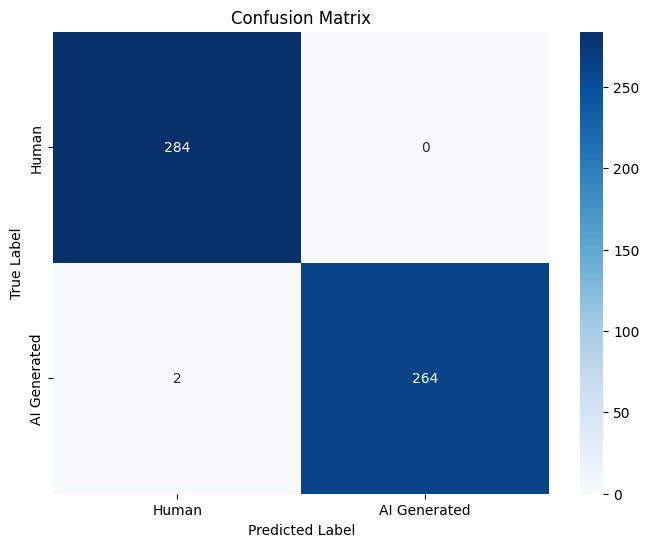

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI Generated'], yticklabels=['Human', 'AI Generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()